In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pandas as pd

In [ ]:
folder_path = r'C:\Users\daV\Documents\ZHAW\HS 2024\dPoDL\dPoDL\experiments\filtered-search\cnns\cifar10\categorical'
sequences = []

# Load all CSVs and extract sequences of loss values
for filename in [i for i in os.listdir(folder_path) if i.endswith(".csv")]:
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            data = pd.read_csv(file_path)
            if len(data) >= 3: 
                values_temp = data['Loss'].values
                if max(values_temp) < 2 and min(values_temp) > 0:  # make sure data makes sense
                    sequences.append(values_temp)
        except Exception as e:
            print(e, filename)


In [2]:
def find_stabilization_point(
    sequence,
    window=5,
    slope_threshold=0.005,
    curvature_threshold=0.05,
    patience=1,
    oscillation_tolerance=0.001,
    increasing_trend_threshold=0.01,
    flat_change_threshold=0.003 
):
    if len(sequence) < window * 2:
        return float("inf")

    # Smooth the sequence using a moving average
    smoothed_sequence = np.convolve(sequence, np.ones(window) / window, mode='valid')

    # Calculate slopes and curvatures
    slopes = np.diff(smoothed_sequence) / smoothed_sequence[:-1]
    curvatures = np.diff(slopes)

    stabilization_count = 0
    for i in range(len(slopes) - window):
        recent_slopes = slopes[i: i + window]
        recent_curvatures = curvatures[i: i + window - 1]

        # Stabilization conditions
        is_stabilized = (
            np.all(np.abs(recent_slopes) < slope_threshold) and
            np.all(np.abs(recent_curvatures) < curvature_threshold)
        )

        # Oscillation detection
        recent_values = smoothed_sequence[i: i + window]
        oscillation_range = np.ptp(recent_values)
        is_oscillating = oscillation_range < oscillation_tolerance

        # Increasing trend detection
        has_increasing_trend = np.all(recent_slopes > increasing_trend_threshold)

        # Flat change detection
        flat_change = np.abs(smoothed_sequence[i + window - 1] - smoothed_sequence[i]) < flat_change_threshold

        if is_stabilized or is_oscillating or flat_change:
            stabilization_count += 1
            if stabilization_count >= patience:
                return i + window
        elif has_increasing_trend:
            return i + window
        else:
            stabilization_count = 0

    return float("inf")



# Example usage:
random.seed(42)
for sequence in random.sample(sequences, 30):
    stable_point = find_stabilization_point(sequence)
    plt.plot(sequence)
    if stable_point < len(sequence):
        plt.axvline(x=stable_point, color='r', linestyle='--', label='stable_point')
        plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss Value")
    plt.show()


NameError: name 'sequences' is not defined

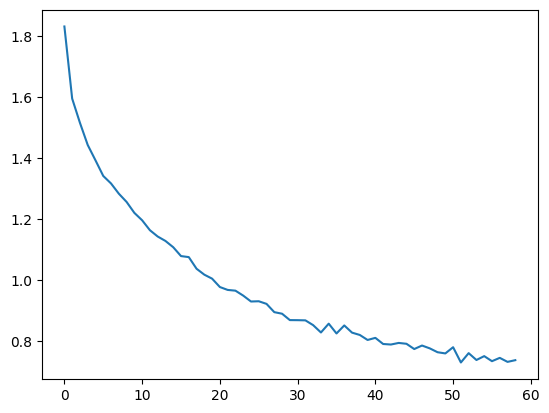

In [4]:
l = [1.8320951461791992, 1.5955309867858887, 1.5160871744155884, 1.4434579610824585, 1.3930164575576782, 1.341736078262329, 1.3170802593231201, 1.2836885452270508, 1.2565947771072388, 1.2206803560256958, 1.1963614225387573, 1.1637976169586182, 1.1431469917297363, 1.128561019897461, 1.107979655265808, 1.0789450407028198, 1.0755856037139893, 1.0374021530151367, 1.0179601907730103, 1.004872441291809, 0.9774206876754761, 0.9679577350616455, 0.965501606464386, 0.9493136405944824, 0.9299600720405579, 0.9307609796524048, 0.9221622347831726, 0.8950297236442566, 0.8898659348487854, 0.8689619302749634, 0.8687101602554321, 0.868104100227356, 0.8523626327514648, 0.8283312320709229, 0.8572772145271301, 0.8251368403434753, 0.8513991236686707, 0.827847957611084, 0.8201762437820435, 0.803780734539032, 0.8107027411460876, 0.7905672788619995, 0.7888193726539612, 0.7940388321876526, 0.7912541627883911, 0.7740083336830139, 0.7855209112167358, 0.7761955261230469, 0.7635555267333984, 0.7596110105514526, 0.7799981236457825, 0.72994065284729, 0.7605689764022827, 0.7380737066268921, 0.7507709264755249, 0.7341954112052917, 0.745072066783905, 0.7319111824035645, 0.7375096082687378]
find_stabilization_point(l)
plt.plot(l)
plt.show()

In [ ]:
# OLD APPROACH

MIN_DECREASE = -0.001
MAX_INCREASE = 0.0005
WINDOW = 20
SLACK_RATE_DECREASE, SLACK_RATE_INCREASE = 0.3, 0.5
SLACK_RATE_DECREASE, SLACK_RATE_INCREASE = SLACK_RATE_DECREASE * WINDOW, SLACK_RATE_INCREASE * WINDOW


def find_stabilization_point(sequence):
    """
    Identifies the point at which the sequence stops significantly decreasing.

    :param sequence: List of float values (the sequence to analyze)
    :return: The index of the first value where the sequence stops significantly decreasing, or None if not found
    """

    if len(sequence) < 2:
        return float("inf")  # A sequence with less than 2 values can't have a significant decrease

    for i in range(WINDOW, len(sequence)):
        s = sequence[i - WINDOW: i]
        if any([s[j+1] < 0.25 * s[0] for j in range(len(s) - 1) ]):  # if any of the following values is smaller than 60% of start value, no we declare no point was found
            return float("inf")
    

    changes = []  # List to track the relative changes in values
    for i in range(1, len(sequence)):
        change = (sequence[i] - sequence[i - 1]) / abs(sequence[i - 1])
        changes.append(change)

    # Check if consecutive changes are consistently smaller than the threshold
    for i in range(WINDOW, len(changes)):
        # Consider the last few changes for oscillation detection
        # check for increasing behaviour:
        s = sequence[i - WINDOW: i]
        condition1 = not any(0.5 * s[0] > [s[j+1]  for j in range(len(s) - 1) ])  # if any of the following values is smaller than 50% of start value, we declare no point was found
        condition1 = True
        if condition1 and [change > MAX_INCREASE for change in changes[i - WINDOW: i]].count(True) >= SLACK_RATE_INCREASE: 
            return i - WINDOW

        # check for decreasing behaviour:
        if condition1 and [change > MIN_DECREASE for change in changes[i - WINDOW: i]].count(True) >= SLACK_RATE_DECREASE:
            return i

    return float("inf")  # No stabilization point found
